In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import gaus2
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [2]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30

# Drift length in cm
DL = 10.0

# Transverse diffusion in cm/sqrt(cm)
DTrans = 0.0135


# Instead of Po210 tracking we simulated charges spreadout along a line with 500 charges per 0.1 cm

In [3]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 500, theta_min = theta_min, theta_max = theta_max, DL = DL, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)


        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        # 1000 electrons per segment
        for left_edge,right_edge in zip(Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=500)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [4]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.08752398460281145, 0.388110518759288, -0.9...","[-0.01977092495905286, -0.45166217964825306, 1...","[[-0.07635812943884887, -0.3792282928971197, 9..."
1,"[-0.23256971161956141, -0.15977668799540454, -...","[0.4573135938993972, 0.487986617520637, 10.0]","[[0.42754024230977256, 0.5047005385426957, 9.9..."
2,"[-0.28854968264751246, -0.031118725801607124, ...","[0.22341716275811752, 0.21142621310463583, 10.0]","[[0.21028368279499476, 0.2112885537211633, 10...."
3,"[-0.2417090006634092, 0.1698449762053542, -0.9...","[-0.44012369343789104, -0.3976785509636044, 10.0]","[[-0.48495152193386115, -0.4080046305029903, 9..."
4,"[0.353934570419037, -0.23290018733239312, -0.9...","[-0.37205581623957973, -0.4601876741462746, 10.0]","[[-0.3281857681922451, -0.4258066901849204, 10..."


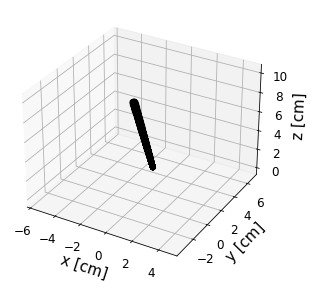

In [5]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

## Check point res versus z of raw simulations

In [6]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

for index, row in tracks.iterrows():

    track = row.track.T

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( track[0], track[1], track[2], np.ones(len(track[0])), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958


    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4

sigma x:  44.04376933884567 +/- 0.10812338255569397
sigma y:  44.300465402155595 +/- 0.10859617390250181
sigma x:  77.60484211376702 +/- 0.16974428655563517
sigma y:  78.46723148453121 +/- 0.1720309174732008
sigma x:  100.043725055626 +/- 0.23076860951253242
sigma y:  100.86070121122414 +/- 0.23374440994121717
sigma x:  -118.2086968282524 +/- 0.30588890542330244
sigma y:  -118.52758020907426 +/- 0.30645625868218035
sigma x:  -133.11187290987763 +/- 0.38978566756742167
sigma y:  134.56960505479543 +/- 0.39874152602344376
sigma x:  146.80727995214238 +/- 0.4870881699100324
sigma y:  149.30789057653405 +/- 0.506806451168329
sigma x:  160.6320536570335 +/- 0.6102007879064277
sigma y:  161.9693609549105 +/- 0.6226034761946573
sigma x:  -171.71110270848914 +/- 0.7272445959006894
sigma y:  174.0518360750362 +/- 0.7527285951041163
sigma x:  -184.14965146104745 +/- 0.8796265801067324
sigma y:  184.7790909042245 +/- 0.8911597741787385
sigma x:  193.9452705043348 +/- 1.0192481651171452
sigma y:  

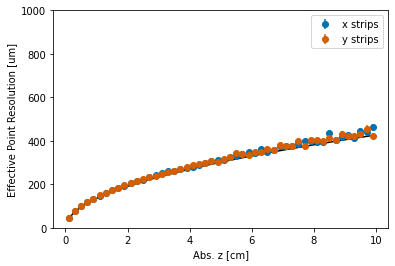

In [7]:
DTrans = 0.0135

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 0/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.ylim([0,1000])
plt.legend()
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

# Now consider a perfect pixel chip readout 

(200um)^3 resolution and no threshold

In [8]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    charges = H[H!=0]
    x_vals = (np.nonzero(H)[0]*0.02)-5
    y_vals = (np.nonzero(H)[1]*0.02)-5
    z_vals = (np.nonzero(H)[2]*0.02)+0.01

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x_vals, y_vals, z_vals, charges, charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958


    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4

sigma x:  121.52547730645703 +/- 1.5599394808312264
sigma y:  123.40388577603647 +/- 1.6048570432545124
sigma x:  -199.44052823801047 +/- 4.114397751385201
sigma y:  -200.85096995812512 +/- 4.210252354272811
sigma x:  268.72080123409876 +/- 8.524139038859257
sigma y:  264.0886231959923 +/- 8.152308557705297
sigma x:  -310.89130775917954 +/- 12.198863226140569
sigma y:  316.51170058593664 +/- 12.783929522157724
sigma x:  341.6246465412728 +/- 15.127662391162163
sigma y:  354.92009708033277 +/- 16.825634542622545
sigma x:  376.46093765334035 +/- 18.925404881968856
sigma y:  394.2848062154354 +/- 22.034448564037774
sigma x:  392.46349264525145 +/- 20.716393150121746
sigma y:  389.05341431812445 +/- 20.325454862124715
sigma x:  425.2271982364222 +/- 25.682087662274583
sigma y:  443.8343732405554 +/- 29.545113532944615
sigma x:  443.61782504543385 +/- 28.316479009338174
sigma y:  466.22699698601707 +/- 33.019830868912805
sigma x:  467.5148226440412 +/- 32.407696805197084
sigma y:  490.48955

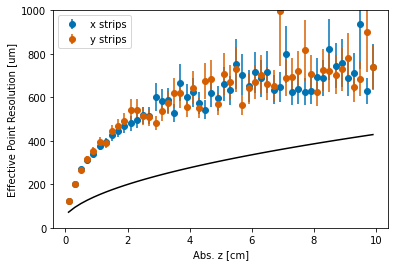

In [9]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.ylim([0,1000])
plt.legend()
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

## This does not look good because we need to weight the mismeasurments 

In [10]:
all_c = np.array([])
all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    charges = H[H!=0]
    x_vals = (np.nonzero(H)[0]*0.02)-5
    y_vals = (np.nonzero(H)[1]*0.02)-5
    z_vals = (np.nonzero(H)[2]*0.02)+0.01

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x_vals, y_vals, z_vals, charges, charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958


    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4

sigma x:  73.43232222369319 +/- 0.4071300698543051
sigma y:  74.18867345860944 +/- 0.4074159428752698
sigma x:  97.44269931401186 +/- 0.515317739108737
sigma y:  98.73915525322344 +/- 0.5363066932934465
sigma x:  116.9390635191636 +/- 0.7228765867871207
sigma y:  117.1823598579917 +/- 0.7290536706711772
sigma x:  -132.70665641706626 +/- 0.9625117069441762
sigma y:  -134.00068900050076 +/- 0.9797800492370089
sigma x:  -145.6599360453413 +/- 1.1822103416363852
sigma y:  148.33500705385066 +/- 1.235672411369143
sigma x:  160.39873445014516 +/- 1.4781838117228745
sigma y:  -160.91837966051133 +/- 1.5006733756674904
sigma x:  172.30982503536956 +/- 1.7665817844306275
sigma y:  171.83207041169882 +/- 1.7543588847627074
sigma x:  182.42911539750057 +/- 2.0436452267478513
sigma y:  -184.65881877236242 +/- 2.1187283580803484
sigma x:  194.89697628556272 +/- 2.4119192967947196
sigma y:  -194.5081179994879 +/- 2.3963737079091456
sigma x:  202.85592743831376 +/- 2.6602344370194815
sigma y:  204.65

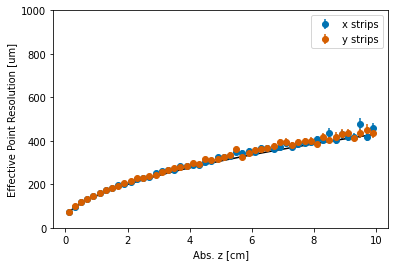

In [11]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim([0,1000])
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

# Now consider a perfect strip readout 

Perfect matching (bin in z first the apply strips), no time integration, 50/50 charge sharing, no threshold, 200 um resolution on all axis 

In [12]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    x_charges = x_hits[x_hits!=0]
    x_pos = (np.nonzero(x_hits)[0]*0.02)-5
    x_zpos = (np.nonzero(x_hits)[1]*0.02)+0.01


    y_charges = y_hits[y_hits!=0]
    y_pos = (np.nonzero(y_hits)[0]*0.02)-5
    y_zpos = (np.nonzero(y_hits)[1]*0.02)+0.01

    x_vals = []
    y_vals = []
    z_vals = []
    charges = []


    # Here the x and y hits are matched based on which z-bin they are in and charge spread along the vetices
    for z in np.arange(-0.02,DL,0.02):

        x_charges_cut = x_charges[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_pos_cut = x_pos[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_zpos_cut = x_zpos[(x_zpos >= z) & (x_zpos < (z+0.02) )]

        y_charges_cut = y_charges[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_pos_cut = y_pos[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_zpos_cut = y_zpos[(y_zpos >= z) & (y_zpos < (z+0.02) )]


        for j in np.arange(len(y_charges_cut)):
            for i in np.arange(len(x_charges_cut)):
                x_vals += [x_pos_cut[i]]
                y_vals += [y_pos_cut[j]]
                z_vals += [z+0.01]
                charges += [ (1.0*x_charges_cut[i]/len(y_charges_cut)) + (1.0*y_charges_cut[j]/len(x_charges_cut)) ]

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4







sigma x:  102.03636009962614 +/- 0.8501808586220551
sigma y:  103.6243635072241 +/- 0.8649308054648924
sigma x:  -157.30921928438664 +/- 1.8461426127812233
sigma y:  -158.27917442054542 +/- 1.869452696296824
sigma x:  184.950531460955 +/- 2.5312334643246066
sigma y:  184.6055924199832 +/- 2.5296455781835734
sigma x:  196.4218210577074 +/- 2.808194418231432
sigma y:  198.9648486100139 +/- 2.9015688237890687
sigma x:  -207.40625868989332 +/- 3.1140166324867034
sigma y:  210.53508964537681 +/- 3.22165804184053
sigma x:  -222.02481706796482 +/- 3.54673093803391
sigma y:  220.61362720915088 +/- 3.5382629833296493
sigma x:  230.43151027219469 +/- 3.8151441990995356
sigma y:  -233.27584336430138 +/- 3.9763306516094286
sigma x:  245.16557649884012 +/- 4.449189332206955
sigma y:  -246.93185806926567 +/- 4.5799265235284405
sigma x:  -253.57193059576989 +/- 4.780264312280325
sigma y:  253.42861623281408 +/- 4.797134523051887
sigma x:  -262.9422494643453 +/- 5.183371218391911
sigma y:  -265.299516

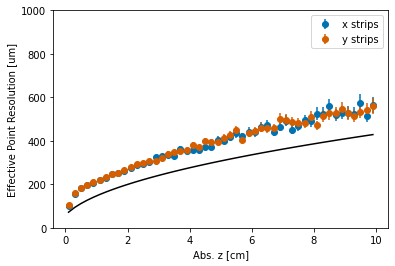

In [13]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim([0,1000])
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

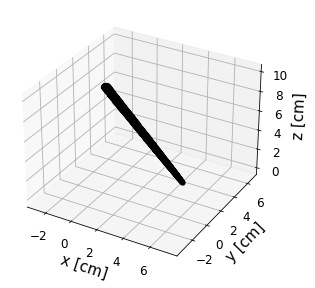

In [14]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals, y_vals, z_vals, c='k', marker='o', alpha=0.1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

This does a little worse for two reasons:
1. The charge distribution is not captured as well for each slice in z, therefore the charge weighting is not as effective
2. Because for each slice in z, every y hit is matched to every x hit, the reconstruction is in the for of rectangles stacked in z (see below)

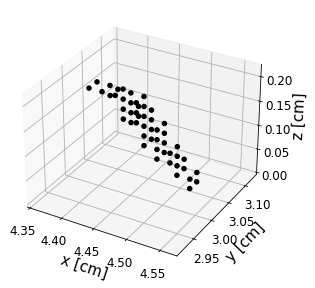

In [15]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals[0:50], y_vals[0:50], z_vals[0:50], c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

# Now consider a perfect strip readout with a digitization time

Perfect matching (bin in z first the apply strips), no time integration, 50/50 charge sharing, no threshold, 200 um resolution on all axis 
However, after a strip has fired, it will not fire again for [delay] bins in z

In [16]:
# Number of z bins the digitization takes, this is consistent with 250ns 
delay = 10

In [17]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track

    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    # If there was a previous hit within the delay window, remove the hit
    for i in np.arange(x_hits.shape[1]-1)+1:

        ref = np.maximum(0,i-delay)
        x_hits_history = x_hits[:,ref:i]
        prev_hit_log = ~(np.sum(x_hits_history,axis=1)>0)

        x_hits[:,i] =  x_hits[:,i] * prev_hit_log

    # If there was a previous hit within the delay window, remove the hit
    for i in np.arange(y_hits.shape[1]-1)+1:

        ref = np.maximum(0,i-delay)
        y_hits_history = y_hits[:,ref:i]
        prev_hit_log = ~(np.sum(y_hits_history,axis=1)>0)

        y_hits[:,i] =   y_hits[:,i] * prev_hit_log

    x_charges = x_hits[x_hits!=0]
    x_pos = (np.nonzero(x_hits)[0]*0.02)-5
    x_zpos = (np.nonzero(x_hits)[1]*0.02)+0.01


    y_charges = y_hits[y_hits!=0]
    y_pos = (np.nonzero(y_hits)[0]*0.02)-5
    y_zpos = (np.nonzero(y_hits)[1]*0.02)+0.01

    x_vals = []
    y_vals = []
    z_vals = []
    charges = []


    # Here the x and y hits are matched based on which z-bin they are in and charge spread along the vetices
    for z in np.arange(0,DL,0.02):

        x_charges_cut = x_charges[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_pos_cut = x_pos[(x_zpos >= z) & (x_zpos < (z+0.02) )]
        x_zpos_cut = x_zpos[(x_zpos >= z) & (x_zpos < (z+0.02) )]

        y_charges_cut = y_charges[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_pos_cut = y_pos[(y_zpos >= z) & (y_zpos < (z+0.02) )]
        y_zpos_cut = y_zpos[(y_zpos >= z) & (y_zpos < (z+0.02) )]


        for j in np.arange(len(y_charges_cut)):
            for i in np.arange(len(x_charges_cut)):
                x_vals += [x_pos_cut[i]]
                y_vals += [y_pos_cut[j]]
                z_vals += [z+0.01]
                charges += [ (1.0*x_charges_cut[i]/len(y_charges_cut)) + (1.0*y_charges_cut[j]/len(x_charges_cut)) ]

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4




sigma x:  83.84683729816497 +/- 2.3508324268586103
sigma y:  86.57206408455306 +/- 2.0496304078460414
sigma x:  -59.46555552000099 +/- 4.86566013225794
sigma y:  152218.53329897995 +/- 12851810963.706423
fit failed for z =  0.5
fit failed for z =  0.7
fit failed for z =  0.9
sigma x:  306.8338136201398 +/- 125.59187070185375
sigma y:  382.8271943081465 +/- 237.6667144343947
fit failed for z =  1.3
sigma x:  211.5528206265082 +/- 36.65414612940979
sigma y:  236.7686005870518 +/- 55.51917713370748
sigma x:  258.45396984611347 +/- 60.88479071516577
sigma y:  150.04798435879044 +/- 14.273152903952425
fit failed for z =  1.9
sigma x:  277.7010483472307 +/- 70.07990197240267
sigma y:  150.79031259936974 +/- 15.024098670250952
sigma x:  2330.3689891279237 +/- 40317.674237182684
sigma y:  236.35782216867267 +/- 49.12091069677325
fit failed for z =  2.5
fit failed for z =  2.7
fit failed for z =  2.9
fit failed for z =  3.1
sigma x:  627.9905465142849 +/- 647.7546976134574
sigma y:  592.1336934

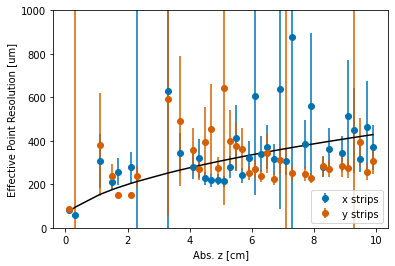

In [18]:
DTrans = 0.0135

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim((0,1000))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

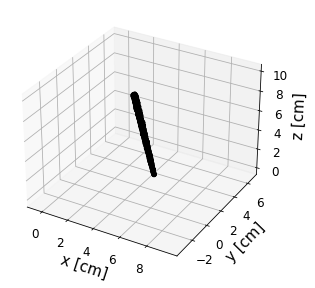

In [19]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals[0], y_vals, z_vals, c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

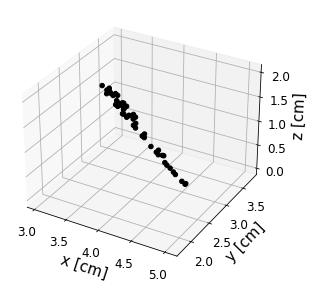

In [20]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals[0:50], y_vals[0:50], z_vals[0:50], c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

# Now consider a perfect strip readout with charge integration

Each strip integrats charge individually, abs z is the charge avergaed position above the strip.

In [21]:
DL = 10.0 

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track
    
    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    x_zpos = []
    x_charges = []
    x_pos = []

    for i in np.arange(x_hits.shape[0]):

        if np.max(x_hits[i,:]) > 0:

            x_zpos += [np.dot( x_hits[i,:], np.arange(len(x_hits[i,:]) ) * 0.02 + 0.01  ) / np.sum(x_hits[i,:])]
            x_pos += [i*0.02-5]
            x_charges +=  [np.sum(x_hits[i,:])]


    y_zpos = []
    y_charges = []
    y_pos = []


    for i in np.arange(y_hits.shape[0]):

        if np.max(y_hits[i,:]) > 0:

            y_zpos += [np.dot( y_hits[i,:], np.arange(len(y_hits[i,:]) ) * 0.02 + 0.01  ) / np.sum(y_hits[i,:])]
            y_pos += [i*0.02-5]
            y_charges +=  [np.sum(y_hits[i,:])]

    y_zpos = np.array(y_zpos)
    y_charges = np.array(y_charges)
    y_pos = np.array(y_pos)
    x_zpos = np.array(x_zpos)
    x_charges = np.array(x_charges)
    x_pos = np.array(x_pos)

    # Match x and y hits if they are within 3 sigma, where sigma is 0.016 cm 

    Tarray = np.abs(np.subtract.outer(x_zpos,y_zpos) / 0.016) < 3

    # This counts the number of simultaniously triggering y hits for each x hit
    TCol = np.sum(Tarray,axis=1)*1.0
    # This counts the number of simultaniously triggering x hits for each y hit
    TRow = np.sum(Tarray,axis=0)*1.0

    unmatched_ADCs = np.append(x_charges[ TCol == 0 ] , y_charges [ TRow == 0 ])
    unmatched_times = np.append( x_zpos[ TCol == 0 ] ,  y_zpos[ TRow == 0 ] )

    # Rebuild arrays, ommiting unmatched hits
    # Convert ADC to electron count units
    x_times = x_zpos[ TCol > 0 ]
    ADC_x = x_charges[ TCol > 0 ]
    strips_x = x_pos[ TCol > 0 ]
    y_times = y_zpos[ TRow > 0 ]
    ADC_y = y_charges[ TRow > 0 ] 
    strips_y = y_pos[ TRow > 0 ]
    Tarray = np.abs((np.subtract.outer(x_times,y_times)) / 0.016) < 3
    TCol = np.sum(Tarray,axis=1)*1.0
    TRow = np.sum(Tarray,axis=0)*1.0

    # This divides the ADC of the x hit by the number of simultaniously triggering y hits
    ADCx_V = np.divide(ADC_x,TCol)

    # This is a matrix of the x ADC contribution to all xy-hits
    elecx_M = np.multiply(ADCx_V[..., None],Tarray)

    # This divides the ADC of the y hit by the number of simultaniously triggering x hits
    ADCy_V = np.divide(ADC_y,TRow)

    # This is a matrix of the y ADC contribution to all xy-hits
    elecy_M = np.multiply(ADCy_V,Tarray)

    # This is the total ADC assigned to each xy-hit
    elec_M = elecx_M+elecy_M

    # This holds the x strip position for each xy-hit
    Stripx_M = np.multiply(strips_x[..., None],Tarray)

    # This holds the y strip position for each xy-hit
    Stripy_M = np.multiply(strips_y,Tarray)

    # This holds the x time measurment for each xy-hit
    Timex_M = np.multiply(x_times[..., None],Tarray)

    # This holds the y time measurment for each xy-hit
    Timey_M = np.multiply(y_times,Tarray)

    # This holds the average time measurment for each xy-hit
    Time_M = (Timex_M + Timey_M) / 2.0

    # absolute time offsets between matched vertices and unmatched hits
    abs_t_off = np.abs( Time_M-np.tensordot(unmatched_times, Tarray, axes=0) )
    # Really we want to weight by the inverse time difference 
    abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)

    # Corresponding umatched ADC and time offset normalization factor
    ADC_norm = unmatched_ADCs/abs_t_off.sum(axis=1).sum(axis=1)

    # Multiply togather and sum to get total unmatched ADC contribution for each vertex
    unmatched_contrib = (abs_t_off*np.tensordot(ADC_norm, Tarray, axes=0)).sum(axis=0)

    # Add to ADC matrix
    elec_M += unmatched_contrib

    # Convert to physical quatities
    x_vals = Stripx_M[Tarray]           # Multiply by pitch for physical distance
    y_vals = Stripy_M[Tarray]           # Multiply by pitch for physical distance
    charges = elec_M[Tarray]            # Weight is number of electrons
    z_vals  = Time_M[Tarray]            # multiply by drift speed for z
    z_vals = z_vals - np.min(z_vals)+0.01                    # Shift z_vals so that minimum is at z=0

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  71.13141705621688 +/- 2.7609547579900133
sigma y:  62.17199384517593 +/- 1.860359781908512
sigma x:  55.77133024873409 +/- 2.1436361177142236
sigma y:  58.49264057878475 +/- 2.5223940661190065
sigma x:  57.48390000133951 +/- 2.540386985759666
sigma y:  51.72648642157899 +/- 2.0460747043285967
sigma x:  53.950027178824556 +/- 2.0925810627281325
sigma y:  49.300609431417335 +/- 1.6102017763598409
sigma x:  54.76781318047539 +/- 2.3253263430573625
sigma y:  55.649509423545496 +/- 2.4763931171715656
sigma x:  64.15451085285272 +/- 3.992130368841078
sigma y:  54.13135546245607 +/- 2.262186492203518
sigma x:  51.183772923037985 +/- 2.0073192598288983
sigma y:  46.8520409271212 +/- 1.4447513842945556
sigma x:  54.30131959887772 +/- 2.270187338944492
sigma y:  49.55727204611212 +/- 1.873897768688948
sigma x:  51.073412325370214 +/- 1.965139191725457
sigma y:  55.04246197086282 +/- 2.676282413418611
sigma x:  45.66252560754727 +/- 1.508168452829056
sigma y:  47.177404036344434 +/- 1.5

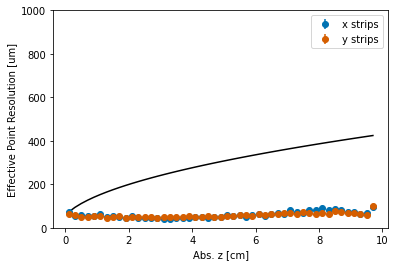

In [22]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim((0,1000))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

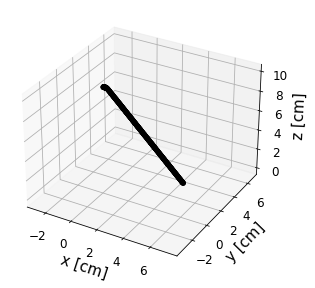

In [23]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals, y_vals, z_vals, c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()

# Now consider a perfect strip readout with charge integration for [bins_integrated] bins

Each strip integrats charge individually, abs z is the charge avergaed position above the strip.

In [24]:
# this is consistent with the peaking time (200 ns)
bins_integrated = 8

In [25]:
DL = 10.0 

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])
all_c = np.array([])



for index, row in tracks.iterrows():

    track = row.track
    
    H, edges = np.histogramdd(track,[np.arange(-5,5,0.02),np.arange(-5,5,0.02),np.arange(0,DL+0.02,0.02)])

    y_hits = np.sum(H,axis=0)
    x_hits = np.sum(H,axis=1)

    x_zpos = []
    x_charges = []
    x_pos = []

    for i in np.arange(x_hits.shape[0]):

        if np.max(x_hits[i,:]) > 0:


            # index of 1st non-zero entry
            i1 = (x_hits[i,:]!=0).argmax(axis=0)
            i2 = i1 + bins_integrated
            
            x_zpos += [np.dot( x_hits[i,i1:i2], (np.arange(len(x_hits[i,:]) ) * 0.02 + 0.01)[i1:i2]  ) / np.sum(x_hits[i,i1:i2])]
            x_pos += [i*0.02-5]
            x_charges +=  [np.sum(x_hits[i,i1:i2])]


    y_zpos = []
    y_charges = []
    y_pos = []


    for i in np.arange(y_hits.shape[0]):

        if np.max(y_hits[i,:]) > 0:

            # index of 1st non-zero entry
            i1 = (y_hits[i,:]!=0).argmax(axis=0)
            i2 = i1 + bins_integrated
            
            y_zpos += [np.dot( y_hits[i,i1:i2], (np.arange(len(y_hits[i,:]) ) * 0.02 + 0.01)[i1:i2]  ) / np.sum(y_hits[i,i1:i2])]
            y_pos += [i*0.02-5]
            y_charges +=  [np.sum(y_hits[i,i1:i2])]

    y_zpos = np.array(y_zpos)
    y_charges = np.array(y_charges)
    y_pos = np.array(y_pos)
    x_zpos = np.array(x_zpos)
    x_charges = np.array(x_charges)
    x_pos = np.array(x_pos)

    # Match x and y hits if they are within 3 sigma, where sigma is 0.016 cm 

    Tarray = np.abs(np.subtract.outer(x_zpos,y_zpos) / 0.016) < 3

    # This counts the number of simultaniously triggering y hits for each x hit
    TCol = np.sum(Tarray,axis=1)*1.0
    # This counts the number of simultaniously triggering x hits for each y hit
    TRow = np.sum(Tarray,axis=0)*1.0

    unmatched_ADCs = np.append(x_charges[ TCol == 0 ] , y_charges [ TRow == 0 ])
    unmatched_times = np.append( x_zpos[ TCol == 0 ] ,  y_zpos[ TRow == 0 ] )

    # Rebuild arrays, ommiting unmatched hits
    # Convert ADC to electron count units
    x_times = x_zpos[ TCol > 0 ]
    ADC_x = x_charges[ TCol > 0 ]
    strips_x = x_pos[ TCol > 0 ]
    y_times = y_zpos[ TRow > 0 ]
    ADC_y = y_charges[ TRow > 0 ] 
    strips_y = y_pos[ TRow > 0 ]
    Tarray = np.abs((np.subtract.outer(x_times,y_times)) / 0.016) < 3
    TCol = np.sum(Tarray,axis=1)*1.0
    TRow = np.sum(Tarray,axis=0)*1.0

    # This divides the ADC of the x hit by the number of simultaniously triggering y hits
    ADCx_V = np.divide(ADC_x,TCol)

    # This is a matrix of the x ADC contribution to all xy-hits
    elecx_M = np.multiply(ADCx_V[..., None],Tarray)

    # This divides the ADC of the y hit by the number of simultaniously triggering x hits
    ADCy_V = np.divide(ADC_y,TRow)

    # This is a matrix of the y ADC contribution to all xy-hits
    elecy_M = np.multiply(ADCy_V,Tarray)

    # This is the total ADC assigned to each xy-hit
    elec_M = elecx_M+elecy_M

    # This holds the x strip position for each xy-hit
    Stripx_M = np.multiply(strips_x[..., None],Tarray)

    # This holds the y strip position for each xy-hit
    Stripy_M = np.multiply(strips_y,Tarray)

    # This holds the x time measurment for each xy-hit
    Timex_M = np.multiply(x_times[..., None],Tarray)

    # This holds the y time measurment for each xy-hit
    Timey_M = np.multiply(y_times,Tarray)

    # This holds the average time measurment for each xy-hit
    Time_M = (Timex_M + Timey_M) / 2.0

    # absolute time offsets between matched vertices and unmatched hits
    abs_t_off = np.abs( Time_M-np.tensordot(unmatched_times, Tarray, axes=0) )
    # Really we want to weight by the inverse time difference 
    abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)

    # Corresponding umatched ADC and time offset normalization factor
    ADC_norm = unmatched_ADCs/abs_t_off.sum(axis=1).sum(axis=1)

    # Multiply togather and sum to get total unmatched ADC contribution for each vertex
    unmatched_contrib = (abs_t_off*np.tensordot(ADC_norm, Tarray, axes=0)).sum(axis=0)

    # Add to ADC matrix
    elec_M += unmatched_contrib

    # Convert to physical quatities
    x_vals = Stripx_M[Tarray]           # Multiply by pitch for physical distance
    y_vals = Stripy_M[Tarray]           # Multiply by pitch for physical distance
    charges = elec_M[Tarray]            # Weight is number of electrons
    z_vals  = Time_M[Tarray]            # multiply by drift speed for z
    z_vals = z_vals - np.min(z_vals)+0.01                    # Shift z_vals so that minimum is at z=0

    z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( np.array(x_vals), np.array(y_vals), np.array(z_vals), np.array(charges), charge_weighting = True)

    ang_z = np.arccos(v_PA[2])*57.2958

    if (ang_z>theta_min) and (ang_z<theta_max):
            
        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
        all_c = np.append(all_c,charges)


# change to um
all_x_err_2 = all_x_err_2 / 1E-4
all_y_err_2 = all_y_err_2 / 1E-4


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  100.81740414452277 +/- 3.7711717610604585
sigma y:  82.41206671353181 +/- 2.658792818775042
sigma x:  60.39846047771654 +/- 2.304134828362638
sigma y:  59.04249824242979 +/- 2.188897449941711
sigma x:  57.68433092714358 +/- 2.1828854930409136
sigma y:  51.947496164115606 +/- 1.810613481460015
sigma x:  54.453007910348745 +/- 2.0041710701537765
sigma y:  57.385169217979794 +/- 2.251555462699911
sigma x:  56.402503871046335 +/- 2.039782654112716
sigma y:  59.98472783961485 +/- 2.1939749068291166
sigma x:  62.65297803435127 +/- 2.107961154595927
sigma y:  66.08931345794153 +/- 2.362254507236332
sigma x:  72.29709243153302 +/- 2.5145023045592727
sigma y:  66.23772145832066 +/- 2.259295359056011
sigma x:  74.40403105573178 +/- 3.0575851679940538
sigma y:  73.75954657403186 +/- 2.9810402745186404
sigma x:  79.09514295660452 +/- 3.2481284007518947
sigma y:  70.19527352090132 +/- 2.101650782818464
sigma x:  74.87441312180104 +/- 2.8299657186404152
sigma y:  76.27663179701119 +/- 2.66

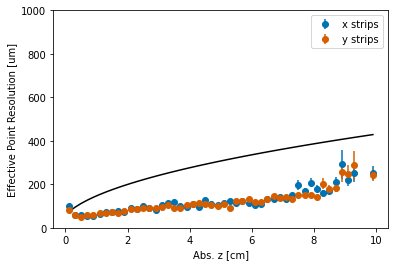

In [26]:

# Get mismeasurement versus abs. z using method 1
abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,  start = 0.0, stop = DL, step = 0.2, plot=False)


plt.figure()
plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
plt.legend()
plt.ylim((0,1000))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()

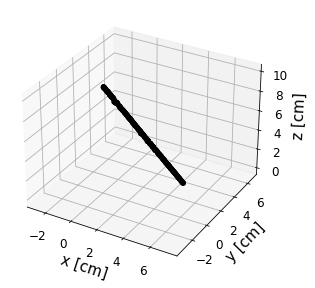

In [27]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x_vals, y_vals, z_vals, c='k', marker='o', alpha=1)

ax.set_xlabel('x [cm]',fontsize=15)
ax.set_ylabel('y [cm]',fontsize=15)
ax.set_zlabel('z [cm]',fontsize=15)
ax.tick_params(labelsize=12)
stripROtools.set_axes_equal(ax)
plt.tight_layout()